In [17]:
import json
import pandas as pd

In [18]:
data = json.load(open('data/train_fraud_labels.json'))

In [19]:
df_transactions = pd.read_csv('data/transactions_data.csv')

In [20]:
df_transactions.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [ ]:
# Yes -> 1, No -> 0
df_transactions.pop("errors")
df_transactions.pop("card_id")

In [21]:
df_transactions['is_fraud'] = df_transactions['id'].apply(lambda x: data["target"][str(x)] if str(x) in data["target"] else "unknown")
df_transactions = df_transactions[df_transactions['is_fraud'] != "unknown"]
df_transactions['is_fraud'] = df_transactions['is_fraud'].apply(lambda x: 1 if x == "Yes" else 0)

df_transactions["amount"] = df_transactions["amount"].apply(lambda x: x.replace("$", "")).astype(float)
df_transactions['amount'] = (df_transactions['amount'] - df_transactions['amount'].mean()) / df_transactions['amount'].std()


In [23]:
df_transactions['is_fraud'].value_counts()

is_fraud
0    8901631
1      13332
Name: count, dtype: int64

In [24]:
df_transactions

,id,date,client_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,is_fraud
0,7475327,2010-01-01 00:01:00,1556,-1.469291,Swipe Transaction,59935,Beulah,ND,58523.0,5499,0
1,7475328,2010-01-01 00:02:00,561,-0.347876,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,0
2,7475329,2010-01-01 00:02:00,1129,0.453415,Swipe Transaction,27092,Vista,CA,92084.0,4829,0
4,7475332,2010-01-01 00:06:00,848,0.042054,Swipe Transaction,13051,Harwood,MD,20776.0,5813,0
5,7475333,2010-01-01 00:07:00,1807,-0.467402,Swipe Transaction,20519,Bronx,NY,10464.0,5942,0
...,...,...,...,...,...,...,...,...,...,...,...
13305905,23761862,2019-10-31 23:54:00,672,-0.367960,Chip Transaction,47508,Cosby,TN,37722.0,7230,0
13305906,23761863,2019-10-31 23:54:00,1384,0.294333,Chip Transaction,58136,Williamson,GA,30292.0,5812,0
13305910,23761868,2019-10-31 23:56:00,1718,-0.512714,Chip Transaction,86438,West Covina,CA,91792.0,5499,0
13305911,23761869,2019-10-31 23:56:00,1766,-0.369552,Online Transaction,39261,ONLINE,NaN,NaN,5815,0


In [25]:
use_chip_unique          = df_transactions['use_chip'].unique()
merchant_category_unique = df_transactions['merchant_city'].unique()
merchant_state_unique    = df_transactions['merchant_state'].unique()
merchant_state_unique = [state for state in merchant_state_unique if pd.notnull(state)]

#
df_transactions["use_chip"] = pd.Categorical(df_transactions["use_chip"], categories=use_chip_unique).codes
df_transactions["merchant_city"] = pd.Categorical(df_transactions["merchant_city"], categories=merchant_category_unique).codes
df_transactions["merchant_state"] = pd.Categorical(df_transactions["merchant_state"], categories=merchant_state_unique).codes


In [26]:
df_transactions_old = df_transactions.copy()

In [27]:
df_transactions_fraud     = df_transactions[df_transactions['is_fraud'] == 1]
df_transactions_non_fraud = df_transactions[df_transactions['is_fraud'] == 0]

In [28]:
len(use_chip_unique), len(merchant_category_unique), len(merchant_state_unique)

(3, 12173, 199)

In [29]:
len(merchant_state_unique)

199

In [30]:
porcent_train = 0.8

df_train = df_transactions.sample(frac=porcent_train)
df_test  = df_transactions.drop(df_train.index)


In [31]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Definir el número de iteraciones y el tamaño de las muestras
num_iterations = 3  # Puedes cambiar este valor para más muestras
sample_size = 500  # Tamaño de cada muestra

# Inicializar el modelo
model = HistGradientBoostingClassifier(max_iter=1000, warm_start=True)

# Listas para almacenar resultados
errors = []
auc_scores = []

df_train_is_fraud  = df_train[df_train['is_fraud'] == 1]
df_train_not_fraud = df_train[df_train['is_fraud'] == 0]
print(df_train_is_fraud.shape, df_train_not_fraud.shape)

for i in range(num_iterations):
    # Crear una muestra aleatoria de 5000 filas
    ind_rand_is_fraud  = np.random.choice(df_train_is_fraud.index, sample_size, replace=False)
    ind_rand_not_fraud = np.random.choice(df_train_not_fraud.index, sample_size, replace=False)

    df_train_sample = pd.concat([df_train_is_fraud.loc[ind_rand_is_fraud], 
                                 df_train_not_fraud.loc[ind_rand_not_fraud]])
    
    # Codificar variables categóricas
    df_train_sample = pd.get_dummies(df_train_sample, columns=['merchant_city', 'merchant_state', 'mcc', 'use_chip'],
                                     drop_first=True, dtype='int64')
    
    # Separar características y etiqueta de fraude
    X = df_train_sample.drop(columns=['id', 'date', 'is_fraud'])
    y = df_train_sample['is_fraud']
    
    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Entrenamiento incremental del modelo
    if i > 0:
        model.set_params(max_iter=model.max_iter + 100)  # Incrementa iteraciones para mejorar en cada paso
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcular error y AUC-ROC
    y_pred = (y_pred_proba >= 0.5).astype(int)  # Usar umbral de 0.5 para clasificar
    error = np.mean(y_pred != y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Almacenar resultados
    errors.append(error)
    auc_scores.append(auc)
    
    print(f"Iteración {i+1} - Error: {error:.4f}, AUC-ROC: {auc:.4f}")

# Mostrar resultados promedio
print("\nResultados Promedio:")
print(f"Error Medio: {np.mean(errors):.4f}")
print(f"AUC-ROC Medio: {np.mean(auc_scores):.4f}")


(10539, 11) (7121431, 11)
Iteración 1 - Error: 0.1050, AUC-ROC: 0.9366
Iteración 2 - Error: 0.3200, AUC-ROC: 0.7011
Iteración 3 - Error: 0.1850, AUC-ROC: 0.8283

Resultados Promedio:
Error Medio: 0.2033
AUC-ROC Medio: 0.8220


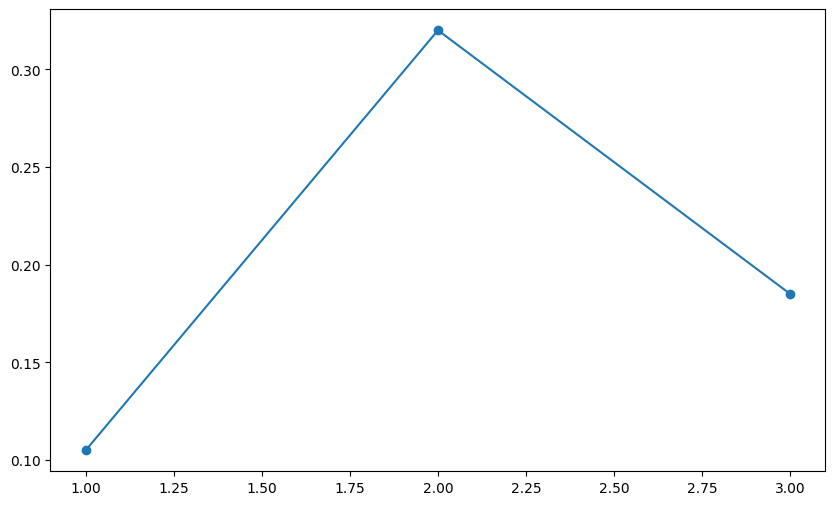

In [32]:
# plot 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), errors, marker='o', label='Error')

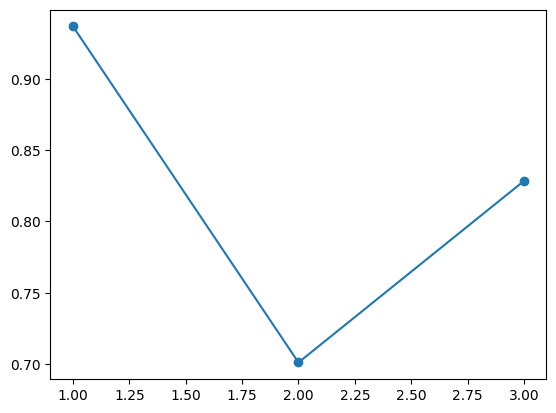

In [33]:
# ROC-AUC
plt.plot(range(1, num_iterations + 1), auc_scores, marker='o', label='AUC-ROC')
